# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
##All major imports are placed here for easier use and 
## to ensure that when called once, they are available throughout notebook
import numpy as np
import torch
import os
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from glob import glob
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               
from tqdm import tqdm

In [4]:
# check if CUDA is available and place all work on GPU
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  All work moved to CPU ...')
else:
    print('CUDA is available!  All work moved to GPU ...')

CUDA is available!  All work moved to GPU ...


In [5]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


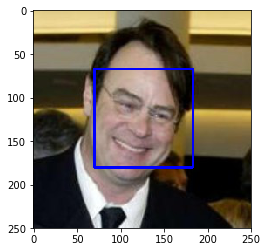

In [6]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)<br>
**98.00%** of the human_files are human faces from the first 100 human faces files.<br>
**17.00%** of the dog_files are dog faces from the first 100 dog faces files.

In [8]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

#keep track of human and dog faces in their respective files
human_faces = 0
dogs_faces = 0

#loop through each human and dog files count the faces using a progress bar
for faces in tqdm(human_files_short):
    if face_detector(faces):
        human_faces+=1
for faces in tqdm(dog_files_short):
    if face_detector(faces):
        dogs_faces+=1

#calculate percentage of human and dog faces
human_faces_percent = (human_faces)/len(human_files_short)*100
dogs_faces_percent = (dogs_faces)/len(dog_files_short)*100

#print out percentages of human and dog faces
print('{:.2f}% of the human_files are human faces.'.format(human_faces_percent))
print('{:.2f}% of the dog_files are dog faces.'.format(dogs_faces_percent))

100%|██████████| 100/100 [00:40<00:00,  2.48it/s]

98.00% of the human_files are human faces.
17.00% of the dog_files are dog faces.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [9]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [10]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
print(VGG16)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 57536310.54it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [11]:
#define image preprocessor used across entire notebook
from PIL import Image
import torchvision.transforms as transforms

def preprocess_image(img_path):
    pil_image = Image.open(img_path)
    #preprocess image
    preprocess_image_transforms = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])
    
    pil_image = preprocess_image_transforms(pil_image).unsqueeze(0)
    if use_cuda:
        pil_image = pil_image.cuda()
    return pil_image

In [12]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    #preprocess image
    image = preprocess_image(img_path)
        
    ## Return the *index* of the predicted class for that image
    VGG16.eval()
    prediction_model = VGG16(image)
    prediction_class = torch.max(prediction_model, 1)[1].item()
    return prediction_class # predicted class index

VGG16_predict(dog_files[0])

243

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    lower_key_index = 151
    higher_key_index = 268
    prediction = VGG16_predict(img_path)
    return prediction >= lower_key_index and prediction <= higher_key_index # true/false

print(dog_detector(dog_files_short[5]))
print(dog_detector(human_files_short[5]))

True
False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__<br> 
**0.00%** of the human_files are human faces from the first 100 human files.<br>
**100.00%** of the dog_files are dog faces from the first 100 dog files.

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
#keep track of human and dog faces in their respective files
human_faces = 0
dogs_faces = 0

#loop through each human and dog files count the faces using a progress bar
for faces in tqdm(human_files_short):
    if dog_detector(faces):
        human_faces+=1

for faces in tqdm(dog_files_short):
    if dog_detector(faces):
        dogs_faces+=1

#calculate percentage of human and dog faces
human_faces_percent = (human_faces)/len(human_files_short)*100
dogs_faces_percent = (dogs_faces)/len(dog_files_short)*100

#print out percentages of human and dog faces
print('{:.2f}% of the human_files are human faces.'.format(human_faces_percent))
print('{:.2f}% of the dog_files are dog faces.'.format(dogs_faces_percent))

100%|██████████| 100/100 [00:04<00:00, 20.84it/s]

0.00% of the human_files are human faces.
100.00% of the dog_files are dog faces.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [15]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

# define densenet201 model
densenet201 = models.densenet201(pretrained=True)

print(densenet201)
#summary(VGG16, (3, 224, 224))

# move model to GPU if CUDA is available
if use_cuda:
    densenet201 = densenet201.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.torch/models/densenet201-c1103571.pth
100%|██████████| 81131730/81131730 [00:13<00:00, 5868973.67it/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [16]:
def densenet201_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    #preprocess image
    image = preprocess_image(img_path)
        
    ## Return the *index* of the predicted class for that image
    densenet201.eval()
    prediction_model = densenet201(image)
    prediction_class = torch.max(prediction_model, 1)[1].item()
    return prediction_class # predicted class index

densenet201_predict(dog_files[24])

243

In [17]:
### returns "True" if a dog is detected in the image stored at img_path
def densenet201_dog_detector(img_path):
    ## TODO: Complete the function.
    
    lower_key_index = 151
    higher_key_index = 268
    prediction = densenet201_predict(img_path)
    return prediction >= lower_key_index and prediction <= higher_key_index # true/false

print(densenet201_dog_detector(dog_files_short[10]))
print(densenet201_dog_detector(human_files_short[15]))

True
False


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [18]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Due to the error - OSError: image file is truncated (150 bytes not processed) has to use ImageFile.LOAD_TRUNCATED_IMAGES = True 
# from an article in stackoverflow at https://stackoverflow.com/questions/26776454/working-with-truncated-images-with-pil
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

root_dir_path = '/data/dog_images/'

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
#Defined transforms for the dog images training, validation and test datasets

datasets_transforms = {'train' : transforms.Compose([transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
                                                    transforms.RandomRotation(25),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ColorJitter(),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                                                         (0.229, 0.224, 0.225))]),
                      'valid' : transforms.Compose([transforms.Resize(255),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                                                         (0.229, 0.224, 0.225))]),
                      'test' : transforms.Compose([transforms.Resize(255),
                                                   transforms.CenterCrop(224),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.485, 0.456, 0.406), 
                                                                        (0.229, 0.224, 0.225))])}

# Load dog datasets with ImageFolder and os path join
images_datasets = {'train' : datasets.ImageFolder(os.path.join(root_dir_path + '/train'), transform=datasets_transforms['train']),
                   'valid' : datasets.ImageFolder(os.path.join(root_dir_path + '/valid'), transform=datasets_transforms['valid']),
                   'test' : datasets.ImageFolder(os.path.join(root_dir_path + '/test'), transform=datasets_transforms['test'])} 

# Dataloader Parameters
# number of subprocesses to use for data loading
num_workers = 0
# number of samples per batch to load
batch_size = 96

#Defining the dataloaders using the dogs image datasets and the tranforms
images_dataloaders = {'train' : torch.utils.data.DataLoader(images_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
                      'valid' : torch.utils.data.DataLoader(images_datasets['valid'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
                      'test' : torch.utils.data.DataLoader(images_datasets['test'], batch_size=batch_size, num_workers=num_workers)}


print('Number of Training Images: ', len(images_datasets['train']))
print('Number of Validation Images: ', len(images_datasets['valid']))
print('Number of Testing Images: ', len(images_datasets['test']))


Number of Training Images:  6680
Number of Validation Images:  835
Number of Testing Images:  836


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:<br>
My code randomly resizes my images by first flipping them horizontally and then cropping them to 224 x 224 as the input tensor because my images are coloured (RGB with a depth of 3) and the required input to the CNN architecture is 224 x 224 x 3.<br>
I used data augmentation under transforms to give my images geometric variation and to allow my CNN to become rotation invariant created by random rotations and translation (scale random resize, flip, rotate and color jitter) and also assist in preventing overfitting in the process.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [19]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # 1st convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # 2nd convolutional layer
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 3rd convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # 4t convolutional layer
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # 5th convolutional layer
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # 1st fully connected hidden linear layer
        self.fc1 = nn.Linear(256 * 7 * 7, 1920)
        # 2nd fully connected hidden linear layer
        self.fc2 = nn.Linear(1920, 1000)
        # final output layer
        self.fc3 = nn.Linear(1000, 133)
        # dropout layer (p=0.45)
        self.dropout = nn.Dropout(0.45) 
    
    def forward(self, x):
        ## Define forward behavior
        # sequence of 5 convolutional and max pooling layers with relu activation function
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        # flatten image input for fully connected layers
        x = x.view(-1, 256 * 7 * 7)
        # dropout layer
        x = self.dropout(x)
        # 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # dropout layer
        x = self.dropout(x)
        # final output layers for network
        x = self.fc3(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=1920, bias=True)
  (fc2): Linear(in_features=1920, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=133, bias=True)
  (dropout): Dropout(p=0.45)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__<br>
In defining the network architecture for my Convolutional Neural Network (CNN) i took the following steps:<br>
1. Under the network init function i defined the CNN layers as follows:<br>
(a)	5 convolution layers and their parameters (input image depth of 3 for RGB image, 16 initial depth of filters for the input image which doubled across each convolution layer, 3x3 kernel/filter size, stride=1 and padding=1 to maintain image dimensions);<br>
(b)	Each convolution layer had a maxpooling layer (with (2 x 2) filter size and stride) after it to discard some spatial information about each convolution layer thereby decreasing their height and weight;<br>
(c)	2 fully connected hidden layers with the first fully connected layer taking flattened downsized stack of feature maps as its input and passing it to the next fully connected hidden layer and then to the final output for class scores prediction for the dog breeds;<br>
(d)	A dropout function (45% p=0.45) to avoid overfitting.<br>
2.	Under the feed forward of the network with input image (x), I did the following:<br>
(a)	Resultant input (x) is flattened into a vector shape and passed as input into fully connected layer;<br>
(b) Passed input in sequence across convolutional layers applying Relu activation function where outputs are passed to pooling layers to produce down sampled transformed inputs (x) which would be returned by the function;<br>
(c)	The dropout function to prevent overfitting and relu activation function are passed in-between the flattened vector input image and the first fully connected layer and then between other fully connected hidden layers and finally a dropout function before the final output layer to produce my desired class score output of 133 possible dog breed outputs.<br>
3.	After defining network model architecture, it was instantiated and moved to GPU for faster training.<br>
4.	Using CrossEntropyLoss function and Adam optimization function for the model and training for 70 epochs, i achieved a test accuracy of 33%.<br>


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [20]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss() #None

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001) #None

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [21]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #clear out any gradients calculations at the start of every batch loop
            optimizer.zero_grad()
            #call model and perfrom a forward pass by model taking input images which are the data batch from our train dataloader
            output = model(data)
            #defined loss function to compare the predicted predicted outputs and the true labels (target) of the images gotten from the train dataloader 
            loss = criterion(output, target)
            #completes the backpropagation steps by performing a backward pass to compute the gradient of the loss
            loss.backward()
            #perform a single optimization step responsible for updating the values of the weights in the network
            optimizer.step()
            #compute the average running training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            #call model and perfrom a forward pass by model taking input images which are the data batch from our train dataloader
            output = model(data)
            #defined loss function to compare the predicted predicted outputs and the true labels (target) of the images gotten from the train dataloader 
            loss = criterion(output, target)
            #compute the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss has decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [22]:
# defining the dataloaders
loaders_scratch = {'train': images_dataloaders['train'], 'valid': images_dataloaders['valid'], 'test': images_dataloaders['test']}

In [23]:
# train the model
model_scratch = train(70, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.880716 	Validation Loss: 4.847216
Validation loss has decreased (inf --> 4.847216).  Saving model ...
Epoch: 2 	Training Loss: 4.747051 	Validation Loss: 4.636641
Validation loss has decreased (4.847216 --> 4.636641).  Saving model ...
Epoch: 3 	Training Loss: 4.598009 	Validation Loss: 4.539733
Validation loss has decreased (4.636641 --> 4.539733).  Saving model ...
Epoch: 4 	Training Loss: 4.466717 	Validation Loss: 4.340767
Validation loss has decreased (4.539733 --> 4.340767).  Saving model ...
Epoch: 5 	Training Loss: 4.302148 	Validation Loss: 4.247764
Validation loss has decreased (4.340767 --> 4.247764).  Saving model ...
Epoch: 6 	Training Loss: 4.177494 	Validation Loss: 4.158645
Validation loss has decreased (4.247764 --> 4.158645).  Saving model ...
Epoch: 7 	Training Loss: 4.093590 	Validation Loss: 4.042621
Validation loss has decreased (4.158645 --> 4.042621).  Saving model ...
Epoch: 8 	Training Loss: 3.971279 	Validation Loss: 3.916823
Valida

In [23]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [25]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.912350


Test Accuracy: 33% (283/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders
# dataloaders defined above will be used

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [48]:
## TODO: Specify model architecture 
model_transfer = models.resnet152(pretrained=True)

# Freeze parameters by turning of gradient for model
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Sequential(nn.Linear(2048, 2048),
                           nn.ReLU(),
                           nn.Dropout(0.25),
                           nn.Linear(2048, 133))
    
print(model_transfer)

#Move model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__<br>
To get to my final CNN architecture, I too the following steps:
1.	I chose resnet152 as my preferred pretrained model because it has been trained on millions of images from imagenet database and it uses deep residual networks and skip connections to fit inputs of previous layers to the next layer without modifications allowing for very deep networks.
2.	I froze all weights at the convolution layers and the adjusted the last layer of fully connected (fc) layer to 133 which is the number of output classes based on the number of dog breeds using nn.Sequential module allowed me to specify each fc layer in sequence using Relu activation function and a dropout of 25%. 
3.	I used CrossEntropyLoss as my loss function to keep track of the loss and gradients of loss of the weights during the training and Adam as my optimization function which updates the weights during training after each epoch. The weights of the fc layer by default were unfrozen and trained because I modified the final fc layer to 133 which is the number of the classes of the dog breeds.
4.	I trained the fully connected (fc) layers for 20 epochs on preprocessed dog images of size 224x224x3 that have been augmented using random scale, random crop, random horizontal flip and color jitter and saved the validation losses  as they decreased across the training epochs in order to be able to load the best model for dog breed prediction after training and was able to get a test accuracy of 86%.



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [49]:
criterion_transfer = nn.CrossEntropyLoss() #None
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001) #None

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [50]:
# defining the dataloaders
loaders_transfer = loaders_scratch

In [51]:
# train the model
n_epochs = 20
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 2.272248 	Validation Loss: 0.761230
Validation loss has decreased (inf --> 0.761230).  Saving model ...
Epoch: 2 	Training Loss: 0.737422 	Validation Loss: 0.598036
Validation loss has decreased (0.761230 --> 0.598036).  Saving model ...
Epoch: 3 	Training Loss: 0.583292 	Validation Loss: 0.469532
Validation loss has decreased (0.598036 --> 0.469532).  Saving model ...
Epoch: 4 	Training Loss: 0.506823 	Validation Loss: 0.464603
Validation loss has decreased (0.469532 --> 0.464603).  Saving model ...
Epoch: 5 	Training Loss: 0.469893 	Validation Loss: 0.455747
Validation loss has decreased (0.464603 --> 0.455747).  Saving model ...
Epoch: 6 	Training Loss: 0.438590 	Validation Loss: 0.431632
Validation loss has decreased (0.455747 --> 0.431632).  Saving model ...
Epoch: 7 	Training Loss: 0.404099 	Validation Loss: 0.463592
Epoch: 8 	Training Loss: 0.398148 	Validation Loss: 0.448865
Epoch: 9 	Training Loss: 0.368487 	Validation Loss: 0.471425
Epoch: 10 	Trainin

In [ ]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [52]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.521593


Test Accuracy: 86% (722/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [63]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
data_transfer = loaders_transfer
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
        
    #preprocess image
    dog_image = preprocess_image(img_path)
    
    model_transfer.eval()
    output = torch.argmax(model_transfer(dog_image)).item()
    return output # predicted class index

predict_breed_transfer(dog_files[0])
predict_breed = class_names[predict_breed_transfer(dog_files[0])]
print(predict_breed_transfer(dog_files[0]))
print("The predicted dog breed is {}.".format(predict_breed))

58
The predicted dog breed is Doberman pinscher.


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

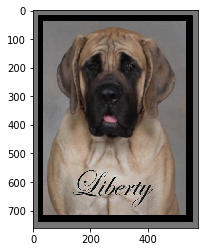

Detected a dog thats look like a Mastiff breed.


In [69]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    dog_face = dog_detector(img_path)
    human_face = face_detector(img_path)
    predict_breed = class_names[predict_breed_transfer(img_path)]
    
    if dog_face:
        print('Detected a dog thats look like a {} breed.'.format(predict_breed))
    elif human_face:
        print('hello, human! \nYou are not a dog but look like the ....\n{} dog breed.'.format(predict_breed))
    else:
        print('Error! - image has neither human nor dog faces in it.')
    return

# Test to see if dog breed is predicted
run_app(dog_files[0])

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)<br>
The output of my algorithm works better than i expected. It predicts dog_faces well and is able to suggest similarities to dog faces from human faces.<br>
However, test accuracy from the modified pretrained model was 86% and i feel it could be improved via the following adjustments:<br>
**1.** Use other pretrained models such as Resnet and Google's InceptionV3 to see whether they would perform better than densenet.<br>
**2.** Change the optimizer used for train the fully connected layers that i adjusted to see if better results can be achieved.<br>
**3.** Adjust the learning rates possibly by using a learning rate scheduler as the network trains and also, increase the number of training epochs to see if the test accuracy will improve.

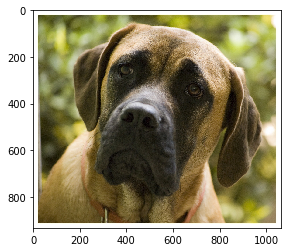

Detected a dog thats look like a Mastiff breed.


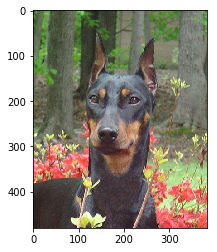

Detected a dog thats look like a Doberman pinscher breed.


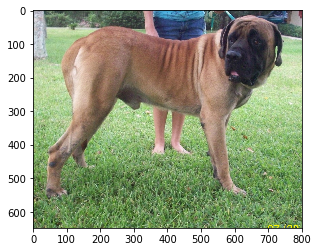

Detected a dog thats look like a Bullmastiff breed.


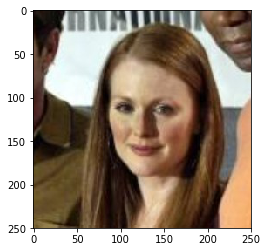

hello, human! 
You are not a dog but look like the ....
Dachshund dog breed.


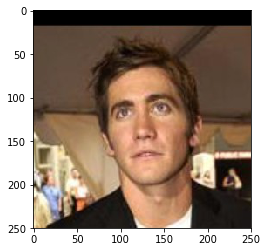

hello, human! 
You are not a dog but look like the ....
Dachshund dog breed.


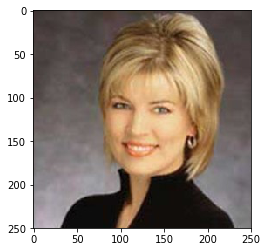

hello, human! 
You are not a dog but look like the ....
Chinese crested dog breed.


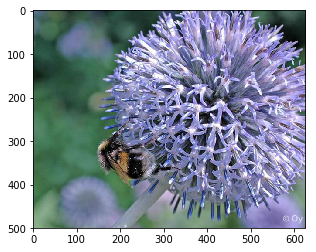

Error! - image has neither human nor dog faces in it.


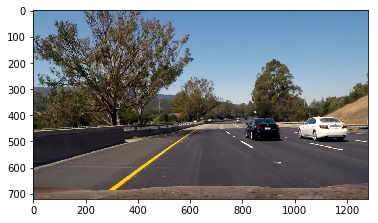

Error! - image has neither human nor dog faces in it.


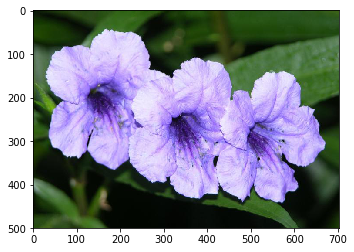

Error! - image has neither human nor dog faces in it.


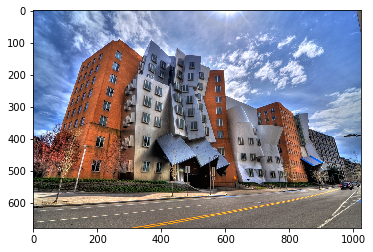

Error! - image has neither human nor dog faces in it.


In [70]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
#using random shuffles to randomly select images from the human and dog files images 
#each time the the run app function is executed
random.seed(95)
random.shuffle(dog_files[:100])
random.shuffle(human_files[:100])

dog_pics = dog_files[:3]
human_pics = human_files[:3]
other_pics = ('other_images/image_07091.jpg', 'other_images/bridge_trees_example.jpg', 'other_images/image_07762.jpg', 'other_images/stata.jpg')
## suggested code, below
for files in np.hstack((dog_pics, human_pics, other_pics)):
    run_app(files)